# Advanced Lane Finding Project 

__The goals / steps of this project are the following:__ 


1- Compute the camera calibration matrix and distortion coefﬁcients given a set of chessboard images.  
2- Apply a distortion correction to raw images.  
3- Use color transforms, gradients, etc., to create a thresholded binary image.  
4- Apply a perspective transform to rectify binary image ("birds-eye view").  
5- Detect lane pixels and ﬁt to ﬁnd the lane boundary.  
6- Determine the curvature of the lane and vehicle position with respect to center.  
7- Warp the detected lane boundaries back onto the original image.  
8- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.  


In [1]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## 1. Calibration of the camera

### a. Find corners

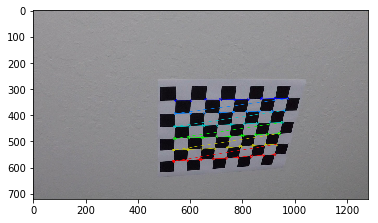

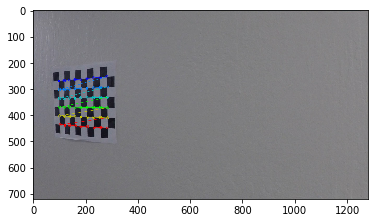

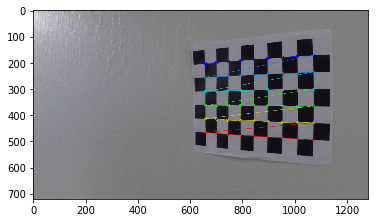

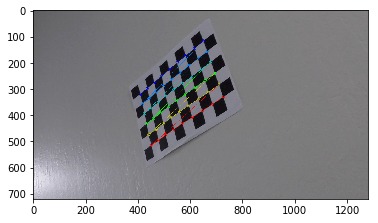

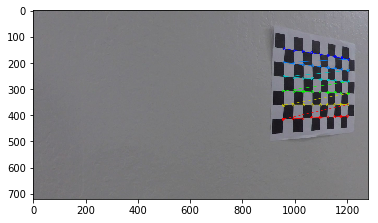

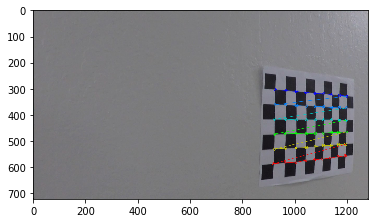

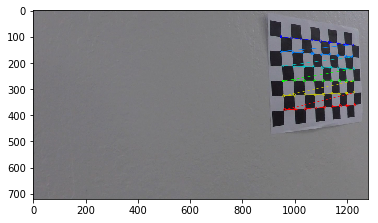

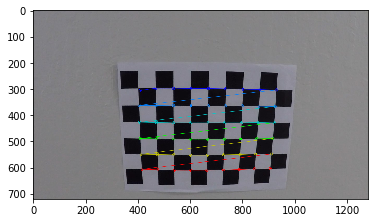

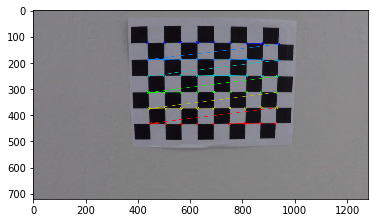

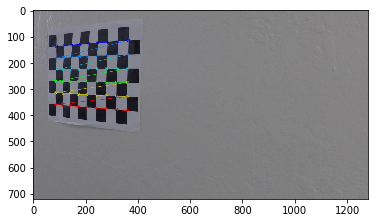

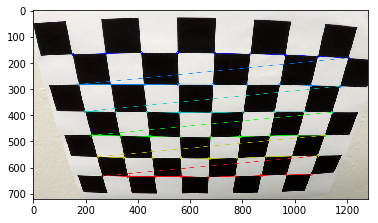

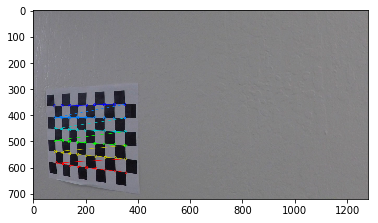

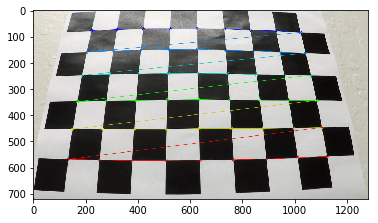

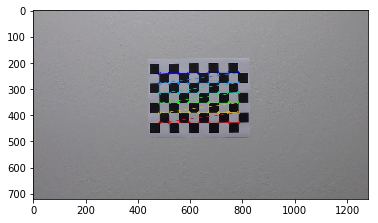

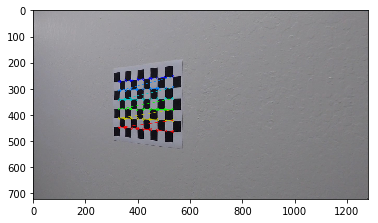

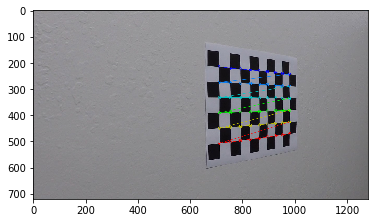

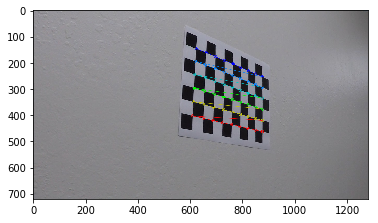

In [17]:
def _build_full_paths(dir_root):
    return [dir_root+'/'+fn for fn in os.listdir(dir_root)]

def find_corners(filenames):
    objpoints, imgpoints = [], [] # 3d points in real world space, # 2d points in image plane.
    
    # Prepare obj points
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    img_size = None
    
    for fn in filenames:
        #reading in an image
        image = mpimg.imread(fn)
        gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if img_size is None:
            img_size = (image.shape[1], image.shape[0])
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            image = cv2.drawChessboardCorners(image, (9,6), corners, ret)
            plt.imshow(image)
            plt.figure()
    
    return objpoints, imgpoints, img_size
    
objpoints, imgpoints, img_size = find_corners( _build_full_paths('camera_cal/') )

### b. Calibrating the camera

In [8]:
def calibrate_camera(objpoints, imgpoints, img_size):
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        return mtx, dist
        
mtx, dist = calibrate_camera(objpoints, imgpoints, img_size)

## 2.  Apply a distortion correction to raw images.

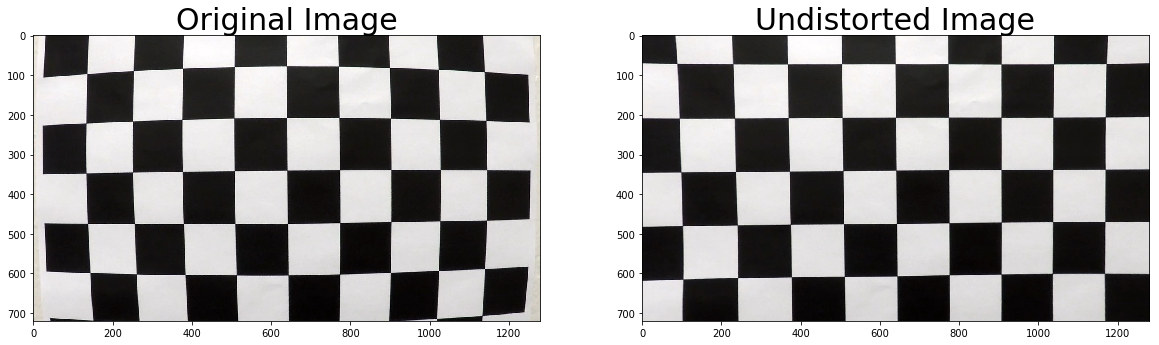

In [26]:
%matplotlib inline

def _show_dist_undist_images_by_2(images):
    for img, dst in images:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=30)

def undistort_image(mtx, dist, img):
    return cv2.undistort(img, mtx, dist, None, mtx)
        
def undistort_images(mtx, dist, filenames):
    undistorted_imgs = []
    
    for fn in filenames:
        img = mpimg.imread(fn)
        
        undst = undistort_image(mtx, dist, img)
        undistorted_imgs.append( (img, undst, ) )
        
    return undistorted_imgs
        
_show_dist_undist_images_by_2( undistort_images(mtx, dist, [ 'camera_cal/calibration1.jpg' ]) )

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

### a. ...

In [36]:
def abs_sobel_threshold(gray, orient='x', sobel_kernel=9, thresh=(20,100)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return this mask as your binary_output image
    return binary_output

In [37]:
def mag_sobel_threshold(gray, sobel_kernel=9, mag_thresh=(30, 100)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255. 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [38]:
def dir_sobel_threshold(gray, sobel_kernel=9, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [43]:
def combined_thresholds(gray, ksize=9, thresh=(20, 100), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3)):
    # Apply each of the thresholding functions
    gradx = abs_sobel_threshold(gray, orient='x', sobel_kernel=ksize, thresh=thresh)
    grady = abs_sobel_threshold(gray, orient='y', sobel_kernel=ksize, thresh=thresh)
    mag_binary = mag_sobel_threshold(gray, sobel_kernel=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_sobel_threshold(gray, sobel_kernel=ksize, thresh=dir_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

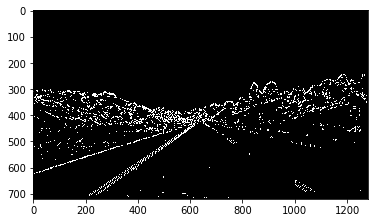

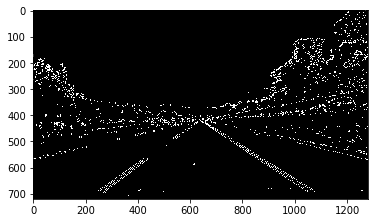

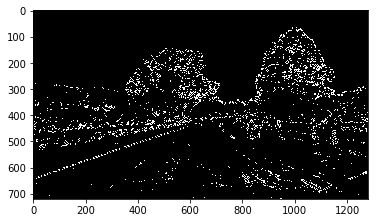

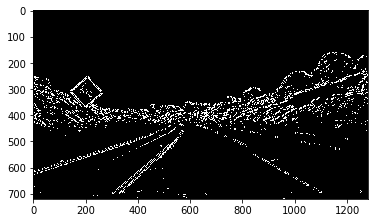

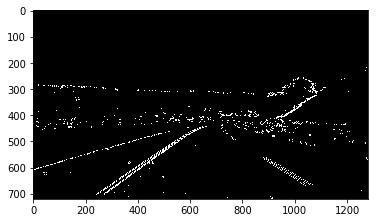

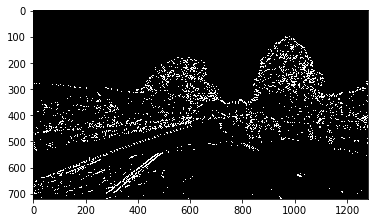

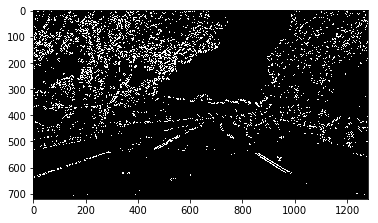

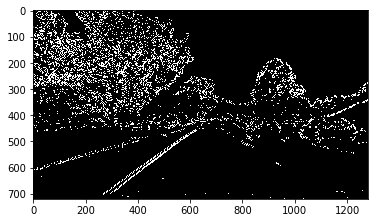

In [53]:
def apply_combined_thresholds(img):
    undist = undistort_image(mtx, dist, img)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    return combined_thresholds(gray)

for fn in _build_full_paths("test_images/"):
    img = mpimg.imread(fn)
    thres_img = apply_combined_thresholds(img)
    plt.imshow(thres_img, cmap='gray')
    plt.figure()
 